This notebook will be used to document assumptions, steps in analyses, etc

## Table of contents

Last access (y.m.d): 19.08.06  
Last update (y.m.d): 19.08.06

- Characteristic frequency calculation 
- New measures for spatial frequency tuning  
- Fourier analysis and F1/F0 ratio calculation

### Basic imports

In [1]:
import os
import numpy as np
import matplotlib
# matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.animation as anim
import matplotlib.cm as cm
import seaborn as sns
import itertools
import helper_fcns as hf
import autoreload
import scipy.optimize as opt
from scipy.stats.mstats import gmean as geomean
import scipy.stats as scst

import sys # so that we can import model_responses (in different folder)
import model_responses

# %matplotlib inline

# also, fix warnings so they don't repeat
import warnings
warnings.filterwarnings('once')

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

## fixed
conDig = 3; # round contrast to the 3rd digit
# at CNS
basePath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/';
# personal mac
# basePath = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/';

## edit
expDir   = 'V1_orig/';
fullWaveform = 0;
which_cell = 2; # which cell - index will be which_cell - 1
df_dogType = 0; # 0 - not DoG; 1 - Sach; 2 - Tony
df_lossType = 2; # 1 - lsq; 2 - sqrt; 3 - poiss; 4 - sach

## now, let it run
dataPath = basePath + expDir + 'structures/'
save_loc = basePath + expDir + 'figures/'

dataList = np.load(dataPath + 'dataList.npy', encoding='latin1').item();
expInd, expType = hf.get_exp_ind(dataPath, dataList['unitName'][which_cell-1])

df_suff = hf.descrMod_name(df_dogType);
dfName = hf.descrFit_name(df_lossType, 'descrFits_190503', modelName=df_suff);

### Characteristic frequency

Here, I'm checking to see if I can compute characteristic frequency for descriptive functions NOT in the difference of gaussian formula. From Enroth-Cugell and Robson ('66):

> $r_c$ is the radius at which the sensitivity of the central summating region falls to 1/e (37 %) of its maximum value 

Thus, we should be able to simply optimize for the frequency (higher than the peak) at which the descriptive tuning curve has a value of 1/e relative to the maximum.

**Conclusion:** We *can't* do this, since the 1/e point for the center mechanism alone is not the same as the 1/e point for the difference of gaussians. This follows from the fact that though the high frequency cutoff is determined entirely by the center mechinism, the exact fall off from the peak is influenced by the strength of the surround mechanism. Thus, the characteristic frequency - as defined in Enroth-Cugell, Robson - can only be computed with a full difference-of-gaussian fit.  

In [2]:
### Load all of the fits
loss_type = 3; # poiss

# "flex" fit
fLname = 'descrFits_190503'
DoGmodel = 0;
modStr  = hf.descrMod_name(DoGmodel)
fLname  = hf.descrFit_name(loss_type, descrBase=fLname, modelName=modStr);
flexFits = hf.np_smart_load(dataPath + fLname)

# sach fit
fLname = 'descrFits'
DoGmodel = 1;
modStr  = hf.descrMod_name(DoGmodel)
fLname  = hf.descrFit_name(loss_type, descrBase=fLname, modelName=modStr);
sachFits = hf.np_smart_load(dataPath + fLname)

First, let's look at the underlying center and surround mechanisms for the DoG fit.

In [3]:
# pick the cell/fits
sfs_plot = np.logspace(-1, 1, 100);
cellInd = 35;
dispInd = 0;
conInd = 0;

In [4]:
# now, get the fit parameters, and plot the underlying mechanisms
ep = sachFits[cellInd]['params'][dispInd][conInd]
r_c = ep[1];
charFreq = 1/(np.pi*r_c)

gauss = lambda gain_c, r_c, f: gain_c*np.pi*np.square(r_c)*np.exp(-np.square(f*np.pi*r_c))
ctrResps = gauss(ep[0], ep[1], sfs_plot);
plt.semilogx(sfs_plot, ctrResps, label='ctr');
plt.semilogx(sfs_plot, gauss(ep[2], ep[3], sfs_plot), label='sur');
plt.axvline(charFreq, c='k', ls='--', label=r'$f_c$');
plt.axhline(np.max(ctrResps)/np.e, c='k', ls='--', label='1/e')

plt.legend();
sns.despine(offset=10);

IndexError: list index out of range

Now, let's compare the center 1/e fall off to the fall off of (a similar) full tuning curve.

In [ ]:
### Now plot
clrs = ['r', 'k'];
lbls = ['sach', 'flex']
f, ax = plt.subplots(2, 1, figsize=(10, 10))

# first, replicate just the DoG curves
gauss = lambda gain_c, r_c, f: gain_c*np.pi*np.square(r_c)*np.exp(-np.square(f*np.pi*r_c))
ctrResps = gauss(ep[0], ep[1], sfs_plot);
ax[0].semilogx(sfs_plot, ctrResps, label='ctr');
ax[0].semilogx(sfs_plot, gauss(ep[2], ep[3], sfs_plot), label='sur');
ax[0].axvline(charFreq, c='k', ls='--', label=r'$f_c$');
ax[0].axhline(np.max(ctrResps)/np.e, c='k', ls='--', label='1/e')
ax[0].set_title('Center and surround')

ax[0].legend();

## sach
ex_params = sachFits[cellInd]['params'][dispInd][conInd];
resps = hf.get_descrResp(ex_params, sfs_plot, 1);
ax[1].semilogx(sfs_plot, resps, label=lbls[0], c=clrs[0])
r_c = ex_params[1];
charFreq = 1/(np.pi*r_c)
ax[1].plot(charFreq, 0, 'v', c=clrs[0], alpha=0.4, label='ctr 1/e')

## flex
ex_params = flexFits[cellInd]['params'][dispInd][conInd];
resps = hf.get_descrResp(ex_params, sfs_plot, 0);
ax[1].semilogx(sfs_plot, resps, label=lbls[1], c=clrs[1])

#########
### now, compute the char freq - cannot infer from parameters, but 1/e (i.e. ~37%) of max from Enroth-Cugell, Robson ('66))
#########
peak_1e = np.max(resps)/np.e;
obj_fun = lambda sf: np.square(peak_1e-hf.get_descrResp(ex_params, [sf], 0)[0])
bnds = [(ex_params[2], sfs_plot[-1])]
cf = opt.minimize(obj_fun, x0=ex_params[2], bounds=bnds, method='COBYLA')
###
#########

ax[1].plot(cf['x'], 0, 'v', c=clrs[1], alpha=0.4, label='full 1/e')
ax[1].set_title('Comparing full versus center characteristic frequency')

ax[1].legend();
sns.despine(offset=10)

As you can see for this example fit, the characteristic frequency (1/e fall off in the center mechanism; red, from difference of gaussian model parameters) is not the same as the 1/e point of the total tuning curve (black; from optimization). Why? Well, of course the relative strength of the surround mechanism matters! If (and only if) the DoG is just the center, then the 1/e of the center and the full curve are equivalent.

Note: Here, the black curve is the descriptive fit as determined by a "flexible" Gaussian - i.e. a Gaussian where the std to the left and right of the peak are independent. As noted by the similarity of the curves (yes, the peaks are offset, but the low/high frequency fall offs are similar), the discrepancy in the characteristic frequencies is not due to curve differences - rather, it is caused by the inequality between the 1/e point for a full curve versus just an underlying center mechanism, as in a DoG.

### Metrics for spatial frequency tuning

While peak spatial frequency, octave bandwidth, and characteristic frequency (or some other measure of high-frequency fall off) are useful measures, they all require a descriptive tuning curve fit. Ideally, we can develop metrics which capture tuning without any model or inference required. To that end, let's consider how we can determine the central tendency and spread of the tuning curves

#### Center of mass

A common calculation in physics, engineering, etc is the center of mass: $x_{cm} = \frac{\sum_{i} x_i \cdot m_i}{M}, M=\sum_i {m_i}$

Can we consider the same form for center of "mass", i.e. the center of the spatial frequency tuning curve? In that case, we write:

$$ f_{cm} = \frac{ \sum_{i} r_i \cdot f_i}{R}, R=\sum_i {r_i}$$

#### ...and SF variance

What about a measure of the spread or non-uniformity of responses. This should be akin to bandwidth, but again, in a model-free way. We can try:

$$ var_{f} = \frac{ \sum_i r_i \cdot \lvert f_i - f_{cm} \rvert}{R} $$

In [ ]:
##########
# Load descriptive fits for comparison
##########

dfits = hf.np_smart_load(dataPath + dfName);

In [ ]:
##########
# compute center of mass, variance
##########

CoM = lambda resp, sf: np.dot(np.log2(sf), np.array(resp))/np.sum(resp)

sfVar = lambda cm, resp, sf: np.dot(resp, np.abs(np.log2(sf)-np.log2(cm)))/np.sum(resp)

In [ ]:
# now, plot an example curve
### For example: 40 (narrow), 1(broad/lowpass), 18 (bandpass)
disp, con = 0, 0;
exInd = 25;

########
# load/organize data
########
exName = dataList['unitName'][exInd];
exCell = hf.np_smart_load(dataPath + exName + '_sfm.npy')
exTr = exCell['sfm']['exp']['trial'];
expInd = hf.get_exp_ind(dataPath, exName)[0];
spks = hf.get_spikes(exTr, expInd=expInd)

sfTuning = hf.organize_resp(spks, exTr, expInd=expInd)[2];
valConds = hf.tabulate_responses(exTr, expInd=expInd)[1];
sfs = valConds[2];

#########
# plot data
#########
resps = sfTuning[disp, :, con];
plt.semilogx(sfs, resps, 'ro');

#########
# plot descriptive fit
#########
curr_df = dfits[exInd]
prms = curr_df['params'][disp][con]
plot_sfs = np.geomspace(sfs[0], sfs[-1], 100);
plot_resp = hf.get_descrResp(prms, plot_sfs, DoGmodel=df_dogType);
plt.semilogx(plot_sfs, plot_resp, c='k');

#########
# compute/plot metrics
#########
peakSf = curr_df['prefSf'][disp][con];
maxResp = np.max(plot_resp)
plt.semilogx(peakSf, 1.1*maxResp, 'v', markersize=8, color='k');

ctr = np.power(2, CoM(resps, sfs));
plt.semilogx(ctr, 1.1*maxResp, 'v', markersize=8, color='r');

sprd = sfVar(ctr, resps, sfs)
plt.title('spread: %.2f' % sprd);

Now, let's ask: how correlated are the model-free and derived measures?

In [ ]:
### Gather
nCells = len(dataList['unitName']);
pks = np.nan * np.zeros((nCells, 2))
var = np.nan * np.zeros((nCells, 2))

for i in range(nCells):
    
    exName = dataList['unitName'][i];
    exCell = hf.np_smart_load(dataPath + exName + '_sfm.npy')
    exTr = exCell['sfm']['exp']['trial'];
    expInd = hf.get_exp_ind(dataPath, exName)[0];
    spks = hf.get_spikes(exTr, expInd=expInd)

    sfTuning = hf.organize_resp(spks, exTr, expInd=expInd)[2];
    valConds = hf.tabulate_responses(exTr, expInd=expInd)[1];

    sfs = valConds[2];
    resps = sfTuning[disp, :, con];

    curr_df = dfits[i]
    peakSf = curr_df['prefSf'][disp][con];
    curr_prms = curr_df['params'][disp][con];
    sfBw = hf.compute_SF_BW(curr_prms, height=0.75, sf_range=[0.01, 10])[1];
    
    ctr = np.power(2, CoM(resps, sfs));
    sprd = sfVar(ctr, resps, sfs);

    # now organize
    pks[i, :] = [peakSf, ctr];
    var[i, :] = [sfBw, sprd];

In [ ]:
### plot
nPlt = 2;
f, ax = plt.subplots(1, nPlt, figsize=(10*nPlt, 10))

# first, peak/center
ax[0].loglog(pks[:, 0], pks[:, 1], 'o');
ax[0].axis('equal')
ax[0].axis('square')
ax[0].set_xlabel('peak SF');
ax[0].set_ylabel('center of mass');
reg = scst.linregress(np.log2(pks[:, 0]), np.log2(pks[:, 1]))
plot_reg = lambda x, b, sf: b + sf*x;
sfs_plot = np.geomspace(np.min(pks[:, 0]), np.max(pks[:, 0]), 100)
ax[0].loglog(sfs_plot, plot_reg(reg.slope, reg.intercept, sfs_plot), 'k--')
ax[0].set_title('correlation: %.2f (p=%.2e)' % (reg.rvalue, reg.pvalue))

# then, bandwidth/spread
ax[1].plot(var[:, 0], var[:, 1], 'o');
ax[1].set_xlabel('SF bw (oct)');
ax[1].set_ylabel('SF var');
non_nan = ~np.logical_or(np.isnan(var[:,0]), np.isnan(var[:, 1]))
reg = scst.linregress(var[non_nan, 0], var[non_nan, 1])
plot_reg = lambda x, b, bw: b + bw*x;
x_plots = np.linspace(np.nanmin(var[:,0]), np.nanmax(var[:,0]))
ax[1].plot(x_plots, plot_reg(reg.slope, reg.intercept, x_plots), 'k--');
ax[1].set_title('correlation: %.2f (p=%.2e)' % (reg.rvalue, reg.pvalue));



So, what do we make of all this?

TODO:
- Try to "index" the SF var metric, i.e. bounded [0, 1].  
- Should we take into account the SD of a particular response? (i.e. higher varaince SF conditions count less towards the calculation)


### Fourier analysis and simple/complex calculation

Though other notebooks have been used to analyze the fourier analysis of recorded spike trains (e.g. phase_plotting.ipynb), the work here will specifically go towards the following:

- how do my fourier amplitudes compare to those from expo?
- how do the fourier amplitudes compare to the DC (i.e. F0 or raw spike count) in overall magnitude?  
- what is the f1/f0 ratio? 

Problem: Nearly all (all?) of the cells are F0 > F1 in this analysis below. That is highly unlikely given that 
we did not consciously exclude simple cells (F1>F0) during data collection. Below are some cells that have been labeled as simple in the bench notes. Let's use these examples to see what's going wrong, if anything.

- m658r07 (V1_orig/35)
- 


In [17]:
######
# initialize, load
######

# variables to set
expDir   = 'V1_orig/';
dl_name  = 'dataList.npy'
which_cell = 35; # which cell - index will be which_cell - 1
df_dogType = 0; # 0 - not DoG; 1 - Sach; 2 - Tony
df_lossType = 2; # 1 - lsq; 2 - sqrt; 3 - poiss; 4 - sach

## now, let it run
dataPath = basePath + expDir + 'structures/'
save_loc = basePath + expDir + 'figures/'

dataList = hf.np_smart_load(dataPath + dl_name);
expInd, expType = hf.get_exp_ind(dataPath, dataList['unitName'][which_cell-1])

df_suff = hf.descrMod_name(df_dogType);
dfName = hf.descrFit_name(df_lossType, 'descrFits_190503', modelName=df_suff);

# load
cell = hf.np_smart_load(dataPath + dataList['unitName'][which_cell-1] + '_sfm.npy');
tr_inf = cell['sfm']['exp']['trial'];
descrFits = hf.np_smart_load(dataPath + dfName);

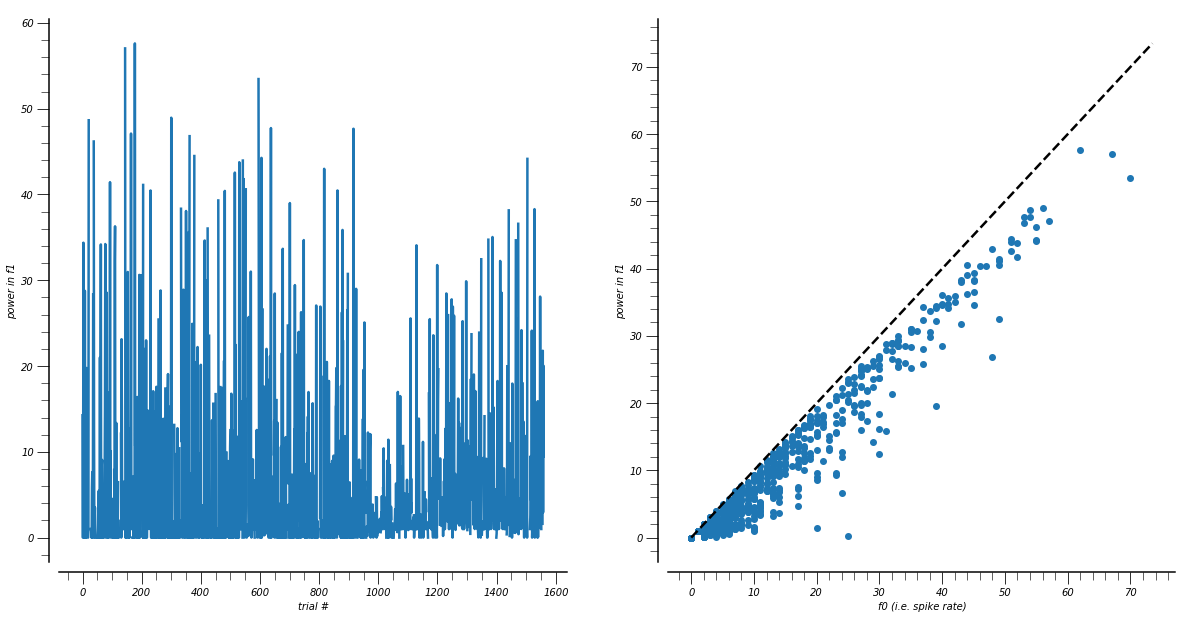

In [18]:
######
# get the expo fourier analysis
######
expo_f1 = np.abs(tr_inf['f1']);
# expo_f1 = np.array([x[0] if np.allclose(x, np.nan, equal_nan=True)==0 else x for x in np.abs(tr_inf['power_f1'])]);

f, ax = plt.subplots(1, 2, figsize=(2*10, 10));

# plot F1
ax[0].plot(expo_f1);
ax[0].set_xlabel('trial #');
ax[0].set_ylabel('power in f1');

# plot F0 vs. F1
spike_count = tr_inf['spikeCount'];
stimDur = hf.get_exp_params(expInd, forceDir=expDir).stimDur;
expo_f0 = spike_count/stimDur;
mn, mx = np.minimum(np.min(hf.nan_rm(expo_f0)), np.min(hf.nan_rm(expo_f1))), np.maximum(np.max(hf.nan_rm(expo_f0)), np.max(hf.nan_rm(expo_f1)))
ax[1].plot(expo_f0, expo_f1, 'o', clip_on=False);
ax[1].plot([mn, 1.05*mx], [mn, 1.05*mx], 'k--')
ax[1].set_xlabel('f0 (i.e. spike rate)');
ax[1].set_ylabel('power in f1');

sns.despine(offset=10)

This seems to be an issue, since the experimental notes have this cell as a simple cell, yet all of the apparent F1 values are lower than the corresponding F0 (i.e. DC or spike rate). First, we can make the observation that the F1 values here are not truly from Expo, but instead seem to be calculated from a function which Robbe wrote as part of the original "SfMixLoad" function which goes from the raw XML to a matlab structure. Let's check to make sure that calcultion is correct!

In [19]:
autoreload.reload(hf)

<module 'helper_fcns' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py'>

In [20]:
nComps = lambda tr_inf, ind: np.sum(np.array([x[ind] for x in tr_inf['con']])>0)
fold_cycle = 2;

In [30]:
autoreload.reload(hf)

<module 'helper_fcns' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py'>

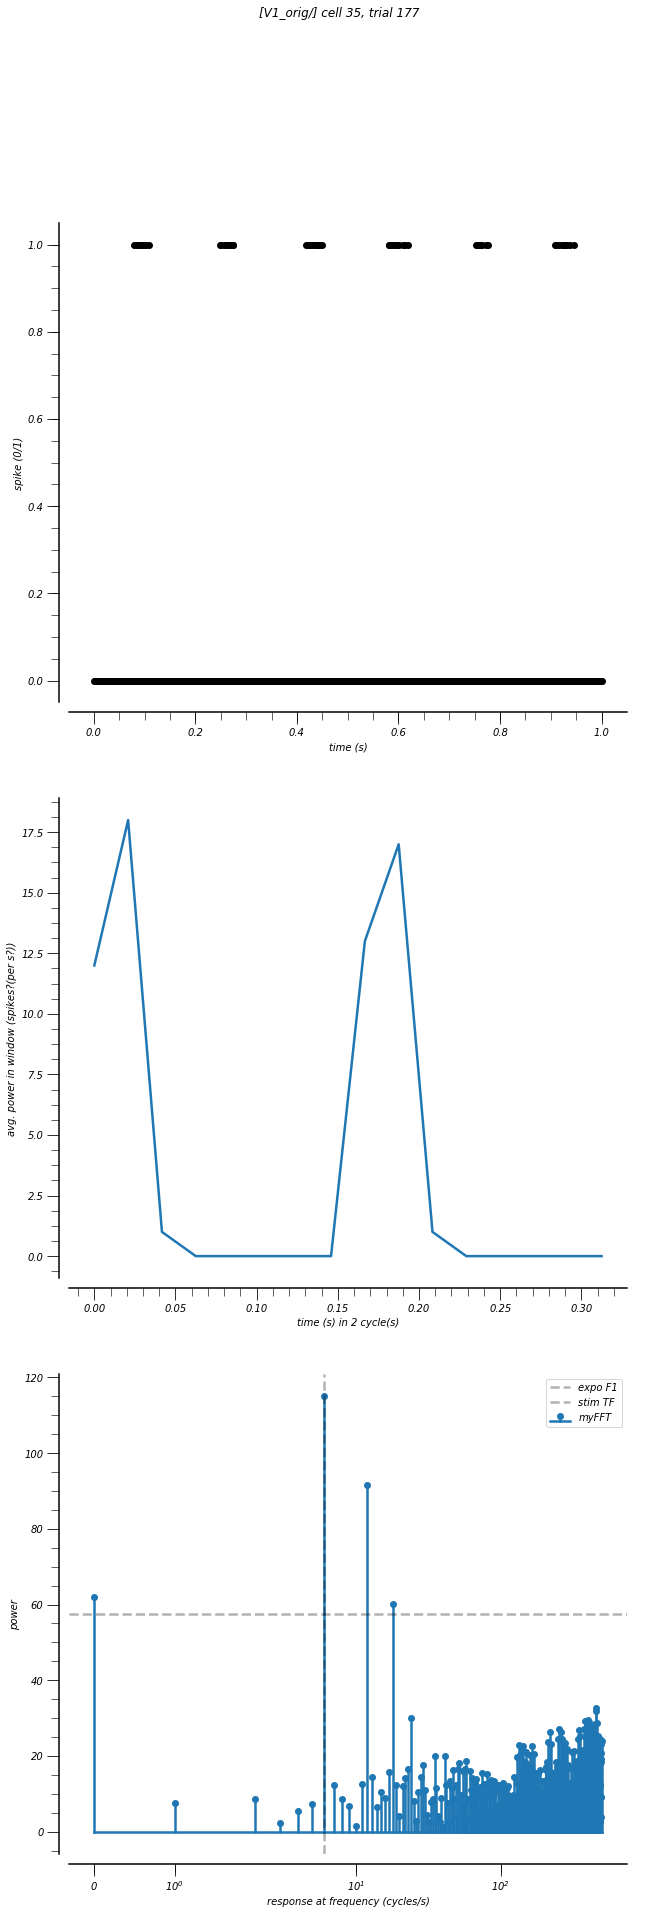

In [31]:
######
# analyze PSTH/FT
######

# let's pick a particular trial to look at - find a single grating case!
# pick the highest-amplitude trial, that is single grating
nth_highest = 0; # 0 is highest

non_nan = np.where(~np.isnan(expo_f1))[0];
sort_asc = np.argsort(expo_f1[non_nan]);
toUse = [];
for i in reversed(sort_asc):
    if nComps(tr_inf, non_nan[i]) == 1:
        if nth_highest == 0:
            toUse = non_nan[i];
            break;
        else:
            nth_highest -= 1;
full_ind = toUse;

spike_times, n_spikes = tr_inf['spikeTimes'][full_ind], spike_count[full_ind];
ph_rel_stim, stim_phase, resp_phase, all_tf = hf.get_true_phase(tr_inf, [full_ind], expInd);
psth, bins = hf.make_psth([spike_times], stimDur=stimDur);
fold, edges, normed = hf.fold_psth(spike_times, all_tf[0], resp_phase[0], n_cycles=fold_cycle, n_bins=8)

## now plot
f, ax = plt.subplots(3, 1, figsize=(1*10, 3*10));

# first plot spike raster (yes, it's binned PSTH, but bin width small enough to have only 1 spike per bin)
ax[0].plot(bins[0][1:], psth[0], 'ko'); # "delist"
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('spike (0/1)')
# then plot folded PSTH
ax[1].plot(edges[0:-1], fold);
ax[1].set_xlabel('time (s) in %d cycle(s)' % fold_cycle)
ax[1].set_ylabel('avg. power in window (spikes?(per s?))')
# finally, let's plot the full FT power spectrum
power, rel_power, full_ft = hf.spike_fft(psth, tfs=all_tf[0], stimDur=stimDur);
ax[2].stem(power[0], basefmt='', label='myFFT');
# and the expo-determined F1
orig_f1 = np.abs(tr_inf['f1'][full_ind])
ax[2].axhline(orig_f1, color='k', ls='--', alpha=0.3, label='expo F1')
tf_xloc = hf.tf_to_ind(all_tf, stimDur)[0];
ax[2].axvline(tf_xloc, color='k', linestyle='--', alpha=0.3, label='stim TF');
# and the DC
dc_rate = spike_count[full_ind] / stimDur;
if dc_rate != power[0][0]: # equivalent to stimDur != 1...
    ax[2].axhline(dc_rate, color='r', linestyle='--', alpha=0.3, label='DC rate (spks/s)');
# adjust the scales/labels
ax[2].set_xscale('symlog')
ax[2].set_xlabel('response at frequency (cycles/s)')
ax[2].set_ylabel('power')
ax[2].legend();
# add title
f.suptitle('[%s] cell %d, trial %d' % (expDir, which_cell, full_ind));
sns.despine(offset=10)

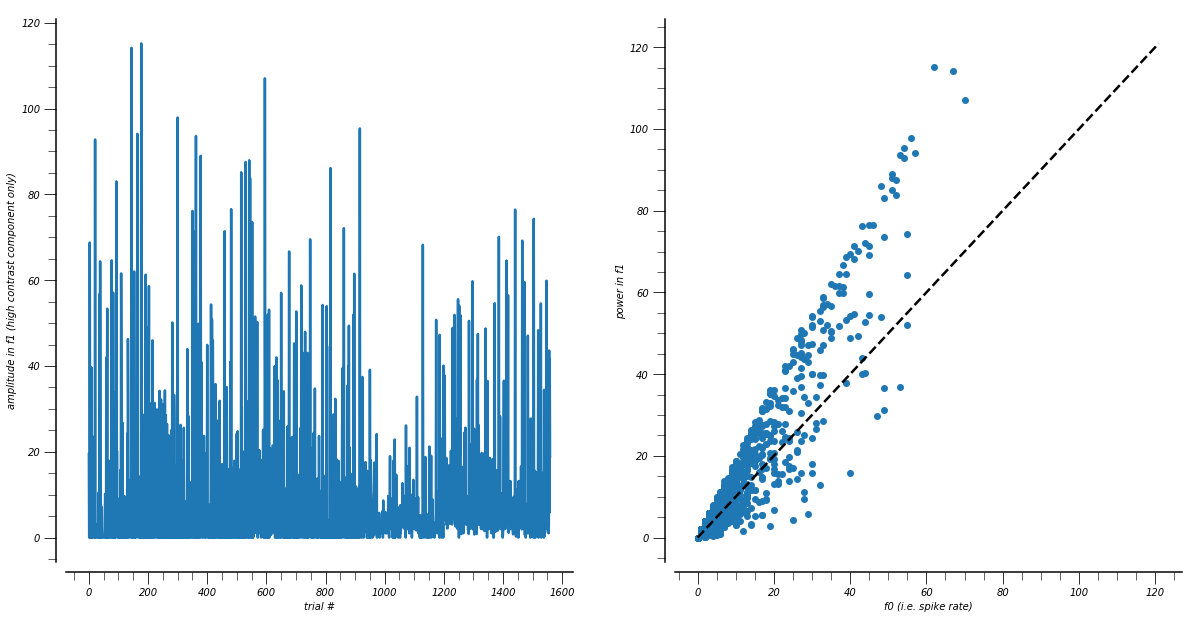

In [151]:
######
# get our own fourier analysis!
######
nTrials = len(tr_inf['num']);
spike_counts = tr_inf['spikeCount'];
spike_times = [tr_inf['spikeTimes'][x] for x in range(nTrials)]; 
psth, bins = hf.make_psth(spike_times, stimDur=stimDur);
all_tf = tr_inf['tf'][0]; # just take first grating???
power, rel_power, full_ft = hf.spike_fft(psth, tfs=all_tf, stimDur=stimDur);

f, ax = plt.subplots(1, 2, figsize=(2*10, 10));

# plot F1
ax[0].plot(rel_power);
ax[0].set_xlabel('trial #');
ax[0].set_ylabel('amplitude in f1 (high contrast component only)');

# plot F0 vs. F1
stimDur = hf.get_exp_params(expInd, forceDir=expDir).stimDur;
expo_f0 = spike_counts/stimDur;
mn, mx = np.minimum(np.min(hf.nan_rm(expo_f0)), np.min(hf.nan_rm(rel_power))), np.maximum(np.max(hf.nan_rm(expo_f0)), np.max(hf.nan_rm(rel_power)))
ax[1].plot(expo_f0, rel_power, 'o', clip_on=False);
ax[1].plot([mn, 1.05*mx], [mn, 1.05*mx], 'k--')
ax[1].set_xlabel('f0 (i.e. spike rate)');
ax[1].set_ylabel('power in f1');

sns.despine(offset=10)

Now it's fixed!!!!!!!!!!!!!!!